<a href="https://colab.research.google.com/github/andreusjh99/Learning-Tensorflow2.0/blob/master/Core1_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This series goes through some of the most common ML algorithms to see how TensorFlow 2.0 works.

1. Regression
2. Classification
3. Clustering
4. Hidden Markov Model 



# Core Learning Algorithms 1 - Regression


## **Linear Regression**

`y = mx + c`

To illustrate, we are going to use a fake dataset.

## Workflow

1. Import stuff
2. Load your dataset using pandas
3. Preprocess the data
4. Create model

## Setup and imports



In [2]:
!pip install -q sklearn

In [3]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [4]:
!python --version

Python 3.6.9


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

In [6]:
print(tf.__version__)

2.2.0


## Creating dataset

Note: this part is just to create data for our regression problem.

The data we are creating is

`y = 0.5x + 5 + n` where `n` is gaussian noise.

In [7]:
# one million data points
x_data = np.linspace(0.0, 10.0, 1000000)

In [8]:
np.random.seed(1000)
noise = np.random.randn(len(x_data))

In [9]:
# creating our labels
m, b = 0.5, 5
y_true = m*x_data + b + noise

In [10]:
# creating a dataframe
my_data = pd.concat([pd.DataFrame(data=x_data, columns=["X Data"]),
                     pd.DataFrame(data=y_true, columns=["Y"])], axis = 1)

In [11]:
my_data.head()

,X Data,Y
0,0.00000,4.195542
1,0.00001,5.320937
2,0.00002,4.974527
3,0.00003,5.644339
4,0.00004,4.699223


## Visualise data

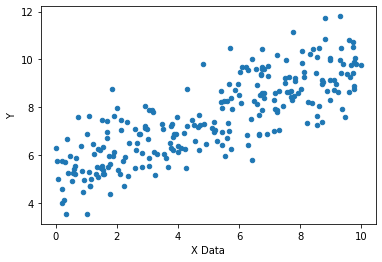

In [12]:
my_data.sample(n = 250).plot(kind='scatter', x='X Data', y="Y")

## Processing the CSV

We parse the values of the features and the labels from the Pandas dataframe. The steps:
1. From the features array. (`X`)
2. Parse the label values. (`y`)
3. Split the `X` and `y` into training and testing datasets.
4. Convert all the arrays to `tf.Tensor` objects.

In [19]:
X = my_data['X Data'].values
y = my_data['Y'].values
# this gives numpy arrays of the X and y values.

# train-test split
train_feats, test_feats, train_labels, test_labels = train_test_split(
    X, y, test_size = 0.2)

# creating tf tensor objects
train_X = tf.constant(train_feats)
train_y = tf.constant(train_labels)
test_X = tf.constant(test_feats)
test_y = tf.constant(test_labels)

## Creating model

Steps:
1. Define loss fn and its deriv
2. Create the model function
3. Define hyperparameters
4. Define `tf.data.Dataset`

We use mean squared error in this problem.

$\Large MSE( y , \hat{y} ) = \frac{ \sum_{i=0}^{N} ( y_i - \hat{y}_i )^2 } { N }$

And its derivative,

$\Large MSE'( y , \hat{y} ) = \frac{ 2 * \sum_{i=0}^{N} ( y_i - \hat{y}_i ) } { N }$

In [20]:
# tf.reduce_mean(x) calculate the mean of all values in the tensor x 
# and returns a reduced tensor.

def mean_squared_error(y, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y))

def mean_squared_error_deriv(y, y_pred):
    return tf.reshape(tf.reduce_mean(2*(y_pred - y)), [1, 1])

We create the regression function from scratch here.

$h(x) = W.X + \mathbf{b}$

In [21]:
def h(X, weights, bias):
    return tf.tensordot(X, weight, axes = 1) + bias

Hyperparameters:
1. epochs
2. batch_size: size of mini-batch used in mini-batch gradient descent
3. learning-rate

We also shuffle our dataset.

In [22]:
num_epochs = 10
num_samples = train_X.shape[0]
batch_size = 20
learning_rate = 0.001

print("No of samples in training dataset: ", num_samples)

No of samples in training dataset:  800000


In [24]:
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
dataset = dataset.shuffle(int(num_samples*1.5)) # shuffles data
dataset = dataset.repeat(num_epochs) # repeats the dataset by num_epochs times
dataset = dataset.batch(batch_size) # creates batches of size = batch_size
iterator = dataset.__iter__()

`dataset.shuffle(num)`
creates a buffer of size `num` and will the buffer up from the dataset, then elements will be selected randomly into a new dataset. 

As a space opens up in the buffer, then a new element will be added into the buffer from the dataset. Usually you would like to create a buffer of size bigger than your dataset for perfect shuffling.